In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

### Reading data

In [2]:
epil_df = pd.read_csv('datasets/epil.csv', sep=',')
epil_df.head()

,Unnamed: 0,y,trt,base,age,V4,subject,period,lbase,lage
0,1,5,placebo,11,31,0,1,1,-0.756354,0.114204
1,2,3,placebo,11,31,0,1,2,-0.756354,0.114204
2,3,3,placebo,11,31,0,1,3,-0.756354,0.114204
3,4,3,placebo,11,31,1,1,4,-0.756354,0.114204
4,5,3,placebo,11,30,0,2,1,-0.756354,0.081414


In [3]:
seizure_df = pd.read_csv('datasets/seizure (1).csv', sep=',')
seizure_df['y'] = seizure_df['y1'] + seizure_df['y2'] + seizure_df['y3'] + seizure_df['y4']
seizure_df['lbase'] = np.log10(seizure_df['base'])
seizure_df['ly'] = np.log10(seizure_df['y'])
seizure_df.head()

,Unnamed: 0,y1,y2,y3,y4,trt,base,age,y,lbase,ly
0,1,5,3,3,3,0,11,31,14,1.041393,1.146128
1,2,3,5,3,3,0,11,30,14,1.041393,1.146128
2,3,2,4,0,5,0,6,25,11,0.778151,1.041393
3,4,4,4,1,4,0,8,36,13,0.903090,1.113943
4,5,7,18,9,21,0,66,22,55,1.819544,1.740363


### Visual exploration

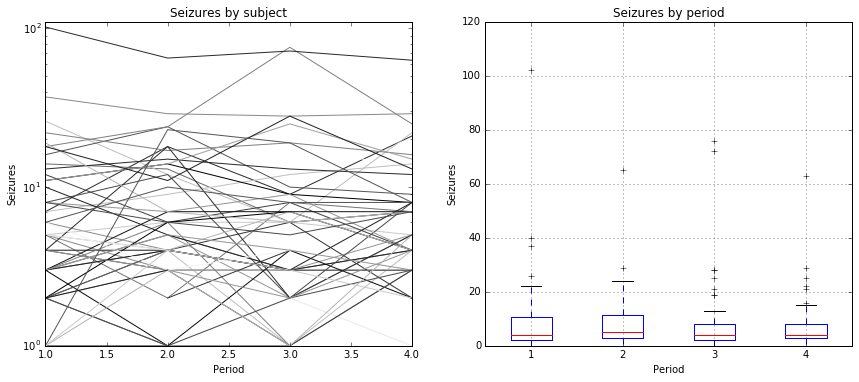

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

min_age, max_age = epil_df['age'].min(), epil_df['age'].max()
age_range = max_age - min_age

for subj_id in set(epil_df['subject'].values):
    subj_df = epil_df[epil_df['subject'] == subj_id]
    color_fac = (float(subj_df['age'].iloc[0]) - min_age) / age_range
    ax[0].semilogy(subj_df['period'], subj_df['y'], color=(color_fac, color_fac, color_fac))
    
ax[0].set_ylim(1, 110)
ax[0].set_title('Seizures by subject')
ax[0].set_xlabel('Period')
ax[0].set_ylabel('Seizures')

epil_df[['y', 'period']].boxplot(figsize=(8,8), by='period', ax=ax[1])
ax[1].set_title('Seizures by period')
ax[1].set_xlabel('Period')
ax[1].set_ylabel('Seizures')

plt.suptitle('')
plt.show()

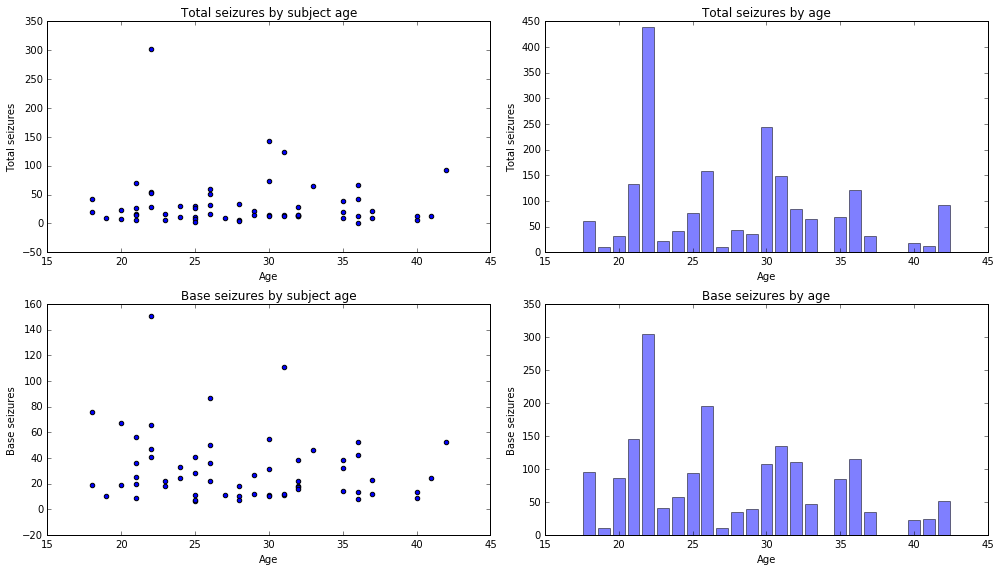

In [5]:
sum_by_subj = epil_df.groupby(['subject']).sum()
counts_by_subj = sum_by_subj['y']
age_by_subj = sum_by_subj['age'] / 4.
base_by_subj = sum_by_subj['base'] / 4.

seizures_by_age =  epil_df.groupby(['age']).sum()['y']
base_by_age = epil_df.groupby(['age']).sum()['base'] / 4.

fig, ax = plt.subplots(2, 2, figsize=(14,8))

ax[0][0].scatter(age_by_subj, counts_by_subj)
ax[0][0].set_xlabel('Age')
ax[0][0].set_ylabel('Total seizures')
ax[0][0].set_title('Total seizures by subject age')

ax[0][1].bar(seizures_by_age.index, seizures_by_age, align='center', alpha=0.5)
ax[0][1].set_xlabel('Age')
ax[0][1].set_ylabel('Total seizures')
ax[0][1].set_title('Total seizures by age')

ax[1][0].scatter(age_by_subj, base_by_subj)
ax[1][0].set_xlabel('Age')
ax[1][0].set_ylabel('Base seizures')
ax[1][0].set_title('Base seizures by subject age')

ax[1][1].bar(seizures_by_age.index, base_by_age, align='center', alpha=0.5)
ax[1][1].set_xlabel('Age')
ax[1][1].set_ylabel('Base seizures')
ax[1][1].set_title('Base seizures by age')

plt.tight_layout()
plt.show()

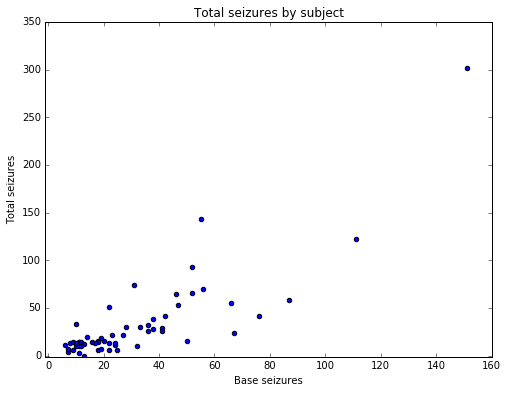

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.scatter(base_by_subj, counts_by_subj)
ax.set_xlabel('Base seizures')
ax.set_ylabel('Total seizures')
ax.set_title('Total seizures by subject')
ax.set_ylim(-1,)
ax.set_xlim(-1,)
plt.show()

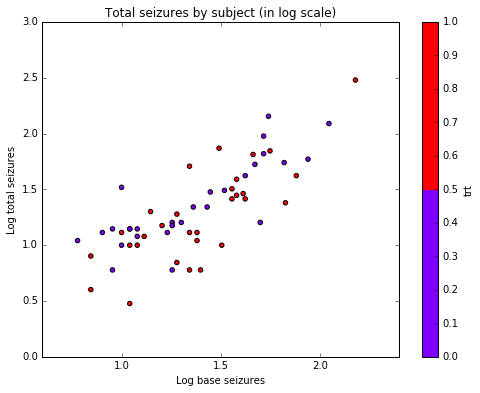

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

seizure_df.plot.scatter(x='lbase', y='ly', c='trt', cmap=plt.cm.get_cmap('rainbow', 2), ax=ax)
ax.set_xlabel('Log base seizures')
ax.set_ylabel('Log total seizures')
ax.set_title('Total seizures by subject (in log scale)')
plt.show()

Do we see any difference between both tratments?

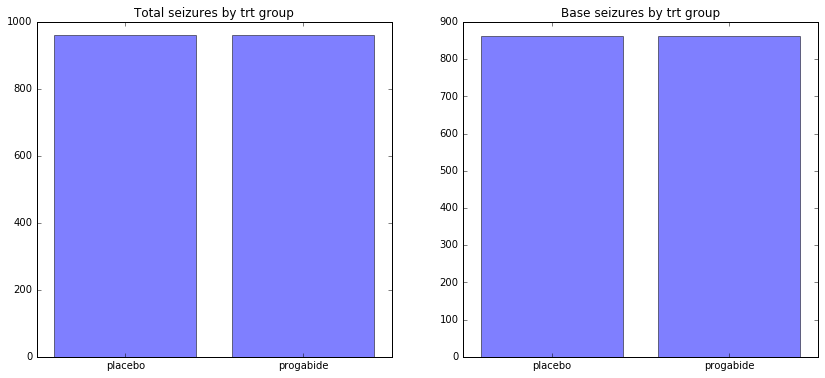

In [8]:
placebo_group = epil_df[epil_df['trt'] == 'placebo']
progabide_group = epil_df[epil_df['trt'] == 'progabide']

seizures_placebo = placebo_group.sum()['y']
seizures_progabide = placebo_group.sum()['y']

base_placebo = placebo_group.sum()['base'] / 4.
base_progabide = placebo_group.sum()['base'] / 4.

fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].bar([1, 2], [seizures_placebo, seizures_progabide], align='center', alpha=0.5)
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['placebo', 'progabide'])
ax[0].set_title('Total seizures by trt group')

ax[1].bar([1, 2], [base_placebo, base_progabide], align='center', alpha=0.5)
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['placebo', 'progabide'])
ax[1].set_title('Base seizures by trt group')

plt.show()

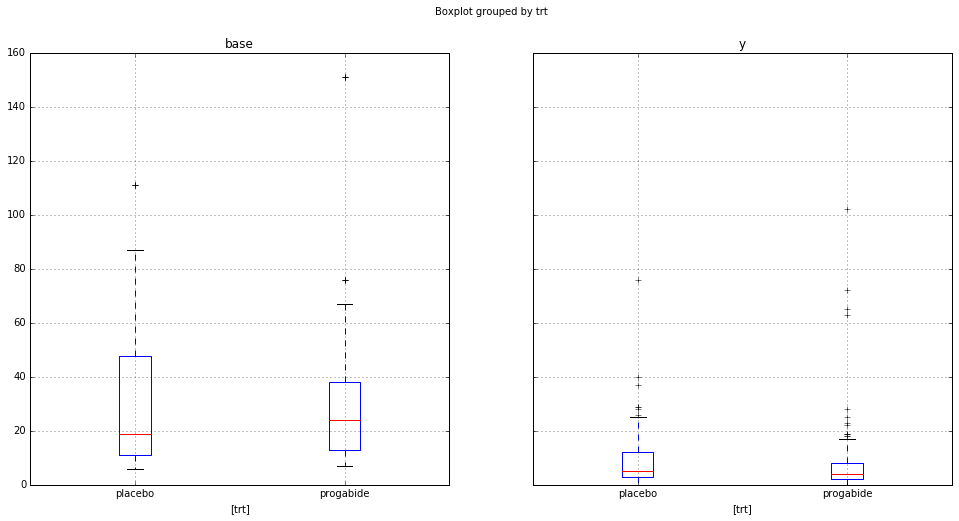

In [9]:
epil_df[['trt', 'y', 'base']].boxplot(figsize=(16,8), by='trt')
plt.show()

### Baseline model

In [10]:
def calculate_model(x_train, y_train, x_test, y_test, x, model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x)
    score_train = model.score(x_train, y_train)
    score_test = model.score(x_test, y_test)
    return score_train, score_test, y_pred

def print_info(title, train_score, test_score):
    print '*** ' + title + ' ***'
    print 'Training score: %.3f' %train_score.mean()
    print 'Testing score: %.3f' %test_score.mean()

def print_results(title, alphas, r_test, r_train, coefs, max_idx):
    print '*** ' + title + ' ***'
    print 'Training score: %.3f' %r_train[max_idx]
    print 'Testing score: %.3f' %r_test[max_idx]
    print 'For alpha = %i' %alphas[max_idx]
    print 'And coefficients: ', coefs[:, max_idx, :].mean(axis=0)

In [16]:
x = seizure_df[['trt', 'base', 'age']]

In [17]:
y_all = seizure_df['y']
y1 = seizure_df['y1']
y2 = seizure_df['y2']
y3 = seizure_df['y3']
y4 = seizure_df['y4']

y0
*** Linear regression ***
Training score: 0.699
Testing score: 0.287
*** Quadratic regression ***
Training score: 0.819
Testing score: 0.137
*** LDA ***
Training score: 0.617
Testing score: 0.056
*** SVC linear ***
Training score: 0.971
Testing score: 0.083
*** SVC quad ***
Training score: 1.000
Testing score: 0.042


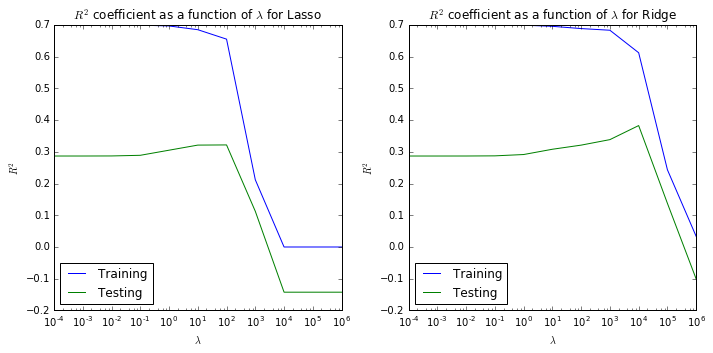

*** Lasso ***
Training score: 0.655
Testing score: 0.322
For alpha = 100
And coefficients:  [ 0.          1.16600684  0.        ]
*** Ridge ***
Training score: 0.612
Testing score: 0.383
For alpha = 10000
And coefficients:  [-0.00362333  0.94295297  0.05045161]
y1
*** Linear regression ***
Training score: 0.660
Testing score: 0.042
*** Quadratic regression ***
Training score: 0.851
Testing score: -0.227
*** LDA ***
Training score: 0.483
Testing score: 0.096
*** SVC linear ***
Training score: 0.686
Testing score: 0.042
*** SVC quad ***
Training score: 1.000
Testing score: 0.125


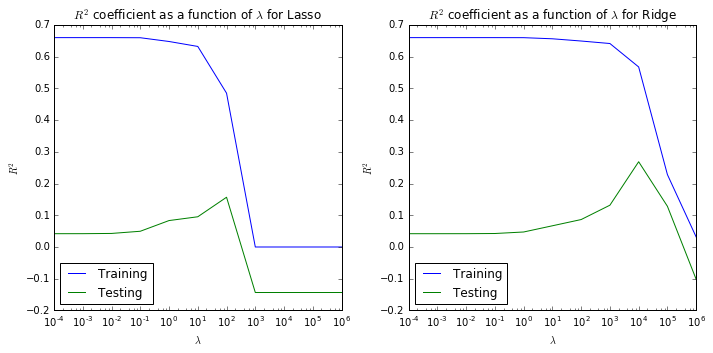

*** Lasso ***
Training score: 0.485
Testing score: 0.157
For alpha = 100
And coefficients:  [ 0.         0.2681593  0.       ]
*** Ridge ***
Training score: 0.567
Testing score: 0.269
For alpha = 10000
And coefficients:  [-0.0009778   0.29980382  0.02810976]
y2
*** Linear regression ***
Training score: 0.683
Testing score: 0.345
*** Quadratic regression ***
Training score: 0.763
Testing score: 0.178
*** LDA ***
Training score: 0.516
Testing score: 0.163
*** SVC linear ***
Training score: 0.943
Testing score: 0.208
*** SVC quad ***
Training score: 1.000
Testing score: 0.208


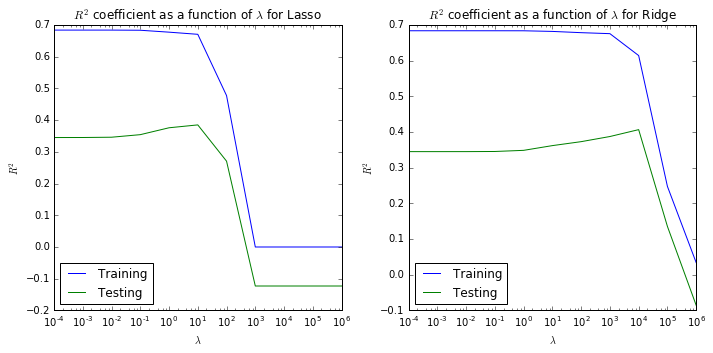

*** Lasso ***
Training score: 0.670
Testing score: 0.385
For alpha = 10
And coefficients:  [ 0.          0.28894036  0.        ]
*** Ridge ***
Training score: 0.614
Testing score: 0.406
For alpha = 10000
And coefficients:  [-0.0002246   0.21618944  0.00043496]
y3
*** Linear regression ***
Training score: 0.458
Testing score: 0.085
*** Quadratic regression ***
Training score: 0.570
Testing score: -1.225
*** LDA ***
Training score: 0.412
Testing score: 0.098
*** SVC linear ***
Training score: 0.714
Testing score: 0.167
*** SVC quad ***
Training score: 1.000
Testing score: 0.083


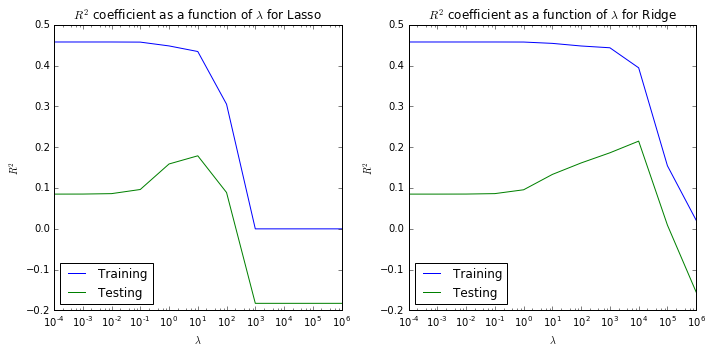

*** Lasso ***
Training score: 0.435
Testing score: 0.179
For alpha = 10
And coefficients:  [ 0.          0.31434258  0.02004622]
*** Ridge ***
Training score: 0.395
Testing score: 0.215
For alpha = 10000
And coefficients:  [-0.00090156  0.22839523  0.01577923]
y4
*** Linear regression ***
Training score: 0.712
Testing score: 0.358
*** Quadratic regression ***
Training score: 0.816
Testing score: -0.037
*** LDA ***
Training score: 0.470
Testing score: 0.126
*** SVC linear ***
Training score: 0.686
Testing score: 0.167
*** SVC quad ***
Training score: 1.000
Testing score: 0.083


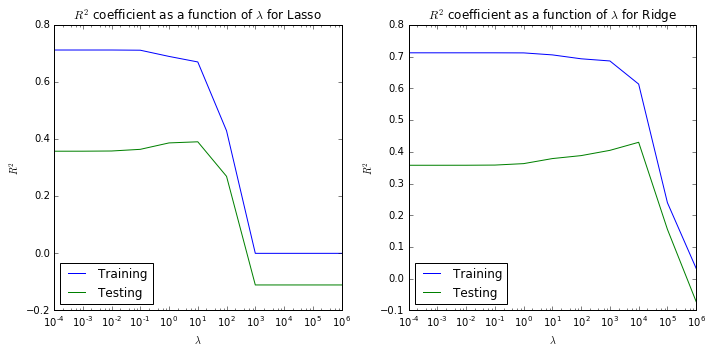

*** Lasso ***
Training score: 0.670
Testing score: 0.390
For alpha = 10
And coefficients:  [ 0.          0.26496967  0.0015502 ]
*** Ridge ***
Training score: 0.613
Testing score: 0.430
For alpha = 10000
And coefficients:  [-0.00144831  0.19859702  0.01041362]


In [18]:
n_iter = 100
alphas = 10.**np.arange(-4, 7)
n_alphas = len(alphas)
n_predictors = x.shape[1]

for y_idx, y in enumerate([y_all, y1, y2, y3, y4]):
    
    print 'y' + str(y_idx)

    r_train = np.zeros(n_iter)
    r_test = np.zeros(n_iter)
    r_train_quad = np.zeros(n_iter)
    r_test_quad = np.zeros(n_iter)
    r_train_lda = np.zeros(n_iter)
    r_test_lda = np.zeros(n_iter)
    r_train_qda = np.zeros(n_iter)
    r_test_qda = np.zeros(n_iter)

    svc_linear_test = np.zeros(n_iter)
    svc_linear_train = np.zeros(n_iter)
    svc_quad_test = np.zeros(n_iter)
    svc_quad_train = np.zeros(n_iter)
    lasso_train = np.zeros((n_iter, n_alphas))
    lasso_test = np.zeros((n_iter, n_alphas))
    lasso_coefs = np.zeros((n_iter, n_alphas, n_predictors))
    ridge_train = np.zeros((n_iter, n_alphas))
    ridge_test = np.zeros((n_iter, n_alphas))
    ridge_coefs = np.zeros((n_iter, n_alphas, n_predictors))

    C = 100

    for idx in range(n_iter):

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6)

        regression = Lin_Reg()
        regression.fit(x_train, y_train)
        r_train[idx] = regression.score(x_train, y_train)
        r_test[idx] = regression.score(x_test, y_test)

        quad_features = preprocessing.PolynomialFeatures(degree=2)
        x_train_quad = quad_features.fit_transform(x_train)
        x_test_quad = quad_features.transform(x_test)
        regression.fit(x_train_quad, y_train)
        r_train_quad[idx] = regression.score(x_train_quad, y_train)
        r_test_quad[idx] = regression.score(x_test_quad, y_test)

        lda = LDA()
        lda.fit(x_train, y_train)
        r_train_lda[idx] = lda.score(x_train, y_train)
        r_test_lda[idx] = lda.score(x_test, y_test)

        #qda = QDA()
        #qda.fit(x_train, y_train)
        #r_train_qda[idx] = qda.score(x_train, y_train)
        #r_test_qda[idx] = qda.score(x_test, y_test)

        svc_linear = SVC(C=C, kernel='linear')
        svc_linear.fit(x_train, y_train)
        svc_linear_train = svc_linear.score(x_train, y_train)
        svc_linear_test = svc_linear.score(x_test, y_test)

        svc_quad = SVC(C=C, kernel='rbf')
        svc_quad.fit(x_train, y_train)
        svc_quad_train = svc_quad.score(x_train, y_train)
        svc_quad_test = svc_quad.score(x_test, y_test)

        for j, alpha in enumerate(alphas):

            lasso = Lasso_Reg(alpha = alpha)
            lasso.fit(x_train, y_train)
            lasso_train[idx, j] = lasso.score(x_train, y_train)
            lasso_test[idx, j] = lasso.score(x_test, y_test)
            lasso_coefs[idx, j] = lasso.coef_

            ridge = Ridge_Reg(alpha = alpha)
            ridge.fit(x_train, y_train)
            ridge_train[idx, j] = ridge.score(x_train, y_train)
            ridge_test[idx, j] = ridge.score(x_test, y_test)
            ridge_coefs[idx, j] = ridge.coef_

    print_info('Linear regression', r_train, r_test)
    print_info('Quadratic regression', r_train_quad, r_test_quad)
    print_info('LDA', r_train_lda, r_test_lda)
    print_info('SVC linear', svc_linear_train, svc_linear_test)
    print_info('SVC quad', svc_quad_train, svc_quad_test)
    #print_info('QDA', r_train_qda, r_test_qda)
    
    r_lasso_train = lasso_train.mean(axis=0)
    r_lasso_test = lasso_test.mean(axis=0)
    r_ridge_train = ridge_train.mean(axis=0)
    r_ridge_test = ridge_test.mean(axis=0)

    fig, ax = plt.subplots(1,2,figsize=(10,5))

    ax[0].semilogx(alphas, r_lasso_train, label='Training')
    ax[0].semilogx(alphas, r_lasso_test, label='Testing')
    ax[0].set_xlabel(r'$\lambda$')
    ax[0].set_ylabel(r'$R^2$')
    ax[0].set_title(r'$R^2$ coefficient as a function of $\lambda$ for Lasso')
    ax[0].legend(loc=3)

    ax[1].semilogx(alphas, r_ridge_train, label='Training')
    ax[1].semilogx(alphas, r_ridge_test, label='Testing')
    ax[1].set_xlabel(r'$\lambda$')
    ax[1].set_ylabel(r'$R^2$')
    ax[1].set_title(r'$R^2$ coefficient as a function of $\lambda$ for Ridge')
    ax[1].legend(loc=3)

    plt.tight_layout()
    plt.show()

    max_lasso = np.argmax(r_lasso_test)
    max_ridge = np.argmax(r_ridge_test)

    print_results('Lasso', alphas, r_lasso_test, r_lasso_train, lasso_coefs, max_lasso)
    print_results('Ridge', alphas, r_ridge_test, r_ridge_train, ridge_coefs, max_ridge)



**Notes:**

* QDA throws the follwing error:
`ValueError: y has only 1 sample in class 0, covariance is ill defined.`

* y0 corresponds to the total number of seizures in the 8-week period after the baseline. y1, y2, y3, and y4 are the number of seizures at each 2-week period.

* Should we normalize the variables?

**Analysis:**

Lasso and Ridge regression are the methods that perform better overall (sometimes Linear regression also does a good job). Based on the coefficients for each predictor (trt, base, and age) we can see that base is the most important predictor in these models. This is expected based on the relation between the two variables visualized in a previous plot (see 'total seizures vs base seizures' above). The second most important factor is age, although not very significant. Lastly, treatment doesn't seem to have any influence on the number ofseizures.